In [55]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import itertools, os
import matplotlib.patches as patches
import random
from sklearn.preprocessing import StandardScaler
from ffb.dataset import load_adult_data, load_german_data, load_compas_data, load_bank_marketing_data

In [59]:
def get_expected_DP(dataset, sensitive_attr):
    data_path = f"datasets/{dataset}/raw"
    if dataset == "adult":
        X, y, s = load_adult_data(path=data_path, sensitive_attribute=sensitive_attr)
    if dataset == "german":
        X, y, s = load_german_data(path=data_path, sensitive_attribute=sensitive_attr)
    if dataset == "compas":
        X, y, s = load_compas_data(path=data_path, sensitive_attribute=sensitive_attr)
    if dataset == "bank_marketing":
        X, y, s = load_bank_marketing_data(path=data_path, sensitive_attribute=sensitive_attr)

    categorical_cols = X.select_dtypes("string").columns
    if len(categorical_cols) > 0:
        X = pd.get_dummies(X, columns=categorical_cols)

    n_features = X.shape[1]
    n_classes = len(np.unique(y))

    numurical_cols = X.select_dtypes("float32").columns
    if len(numurical_cols) > 0:

        def scale_df(df, scaler):
            return pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)

        scaler = StandardScaler().fit(X[numurical_cols])

        def scale_df(df, scaler):
            return pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)

        X[numurical_cols] = X[numurical_cols].pipe(scale_df, scaler)
    X["y"] = y

    acc_rate_0 = len(X[(s[sensitive_attr] == 0) & (X["y"] == 1)])/len(X[(s[sensitive_attr] == 0)])
    acc_rate_1 = len(X[(s[sensitive_attr] == 1) & (X["y"] == 1)])/len(X[(s[sensitive_attr] == 1)])
    expected_DP = np.abs(acc_rate_1 - acc_rate_0)

    return expected_DP

def compute_all_expected_DPs():
    datasets = {
        "adult" : ["race", "sex"],
        "compas" : ["race", "sex"],
        "bank_marketing" : ["age"],
        "german" : ["age", "sex"]
    }
    for dataset in datasets.keys():
        for sensitive_attr in datasets[dataset]:
            expected_DP = get_expected_DP(dataset, sensitive_attr)
            print(f"{dataset}, {sensitive_attr}, DP = {expected_DP}")

compute_all_expected_DPs()
            

adult, race, DP = 0.13606965980520994
adult, sex, DP = 0.198901432678815
compas, race, DP = 0.09745618466614941
compas, sex, DP = 0.1279983309134417
bank_marketing, age, DP = 0.13042819108218418
german, age, DP = 0.14944769330734242
german, sex, DP = 0.07480130902290782


In [3]:

def generate_distinct_colors(n):
    colors = plt.cm.tab20.colors
    hex_colors = [matplotlib.colors.rgb2hex(color) for color in colors]
    local_random = random.Random(3)

    local_random.shuffle(hex_colors)
    
    # If n is greater than 20, repeat the colors
    hex_colors = hex_colors * (n // 20) + hex_colors[:n % 20]
    
    return hex_colors[:n]

def generate_distinct_linestyles(n):
    linestyles = ['-', '--', '-.', ':']
    linestyles = linestyles * (n // len(linestyles)) + linestyles[:n % len(linestyles)]
    return linestyles[:n]

def generate_distinct_markers(n):
    markers = ['o', 's', 'v', '^', '<', '>', 'd', 'p', '*', 'h', 'H', '+', 'x', 'D', '|', '_']
    markers = markers * (n // len(markers)) + markers[:n % len(markers)]
    return markers[:n]

def hex_to_rgb(hex_code):
    hex_code = hex_code.lstrip('#')
    return tuple(int(hex_code[i:i+2], 16) for i in (0, 2, 4))

def rgb_to_hex(rgb_tuple):
    return '#{:02x}{:02x}{:02x}'.format(*rgb_tuple)

def combine_colors(hex_list):
    if not hex_list:
        return None
    
    total_rgb = [0, 0, 0]
    num_colors = len(hex_list)
    
    for hex_code in hex_list:
        rgb = hex_to_rgb(hex_code)
        total_rgb = [sum(x) for x in zip(total_rgb, rgb)]
    
    averaged_rgb = tuple(val // num_colors for val in total_rgb)
    return rgb_to_hex(averaged_rgb)

In [69]:
def make_plots(to_plot_params):
    
    time_horizon = 150
    metrics_to_plot = ["dp", "acc_cost", "acc_util", "n_interventions"]
    
    
    keys = to_plot_params.keys()
    values = to_plot_params.values()

    # Create all combinations of the parameter values
    product = itertools.product(*values)

    # For each combination, create a dictionary where the keys are mapped to the respective values
    labels_to_plot = [dict(zip(keys, combination)) for combination in product]

    n = len(labels_to_plot)
    colors = generate_distinct_colors(n)
    linestyles = generate_distinct_linestyles(n)
    markers = generate_distinct_markers(n)



    basic_info = ""
    shared_params = []

    for key in to_plot_params.keys():
        if len(to_plot_params[key]) == 1:
            shared_params.append(key)
            basic_info += f"{key}={to_plot_params[key][0]}-"
    basic_info = basic_info[:-1]

    for k in range(len(labels_to_plot)):

        labelstr = ""
        for key in to_plot_params.keys():
            if key not in shared_params:
                labelstr += f"{key}={labels_to_plot[k][key]}-"
        labelstr = labelstr[:-1]
        labels_to_plot[k]["label"] = labelstr
        labels_to_plot[k]["color"] = colors[k]
        labels_to_plot[k]["marker"] = markers[k]
        labels_to_plot[k]["linestyle"] = linestyles[k]



    for d in labels_to_plot:
        dp_threshold_str = f"{d['dp_threshold']:.4f}".split('.')[1]
        clean_filename = f"{d['dataset']}_{d['sensitive_attr']}_{d['ml_algo']}_{time_horizon}_{d['cost_type']}_{d['n_cost_bin']}_{dp_threshold_str}_{d['lambda_decision']}_"
        os.listdir("experimental_results/simulation_results/")
        data_path_list = [k for k in os.listdir("experimental_results/simulation_results/") if clean_filename in k]
        if len(data_path_list) == 0:
            raise Exception(f"No data found for {d}")
        for i in range(len(data_path_list)):
            data_path = f"experimental_results/simulation_results/{data_path_list[i]}"
            tmp_df = pd.read_csv(data_path, index_col = 0)
            tmp_df["acc_cost"] = tmp_df["cost"].cumsum()
            tmp_df["intervention"] = (tmp_df['cost'] != 0).astype(int)
            tmp_df["n_interventions"] = tmp_df["intervention"].cumsum()
            tmp_df["acc_util"] = tmp_df["utility"].cumsum()
            tmp_df['step'] = tmp_df.index
            tmp_df['sim_num'] = i
            if i == 0:
                df = tmp_df.copy()
            else:
                df = pd.concat([df, tmp_df], ignore_index = True)

            for metric in metrics_to_plot:
                d[metric] = {}
                d[metric]["med"] = df[['step', metric]].groupby('step').quantile(0.50)[metric].values
    #             d[metric]["med"] = df[['step', metric]].groupby('step').mean(0)[metric].values
                d[metric]["min"] = df[['step', metric]].groupby('step').quantile(0.25)[metric].values
                d[metric]["max"] = df[['step', metric]].groupby('step').quantile(0.75)[metric].values
            # these are stated as med: medium, min, max for plot. They could be mean+-std as well (see commented out)
        steps = tmp_df['step'].unique()
        
        
    
    linewidth = 2

    for metric in metrics_to_plot:

        # Create the plot
        fig, ax = plt.subplots(figsize=(9,5))

        # plt.figure(figsize=(10, 6))

        for d in labels_to_plot:
            plt.plot(steps, d[metric]["med"], 
                     color = d["color"], marker = d["marker"], 
                     linestyle = d["linestyle"], linewidth = linewidth, label = d["label"])
            plt.fill_between(steps, d[metric]["min"], d[metric]["max"],
                            color = d["color"], alpha = 0.2)



        for spine in ['right', 'top']:
            ax.spines[spine].set_visible(False)

        # Add labels and title
        if metric == "dp":
            dp_targets = set()
            for d in labels_to_plot:
                dp_targets.add(d["dp_threshold"])
            for dp_target in dp_targets:
                colorlist = []
                for d in labels_to_plot:
                    colorlist.append(d["color"])
                color = combine_colors(colorlist)

                plt.axhline(dp_target, linestyle='dashed', label="Target DP",
                            xmin = 0.05, xmax = 0.96, color = color)
            for dataset in to_plot_params["dataset"]:
                for sensitive_attr in to_plot_params["sensitive_attr"]:
                    expected_DP = get_expected_DP(dataset, sensitive_attr)
                    plt.axhline(expected_DP, linestyle='dashed', 
                                label=f"Expected DP for {dataset}-{sensitive_attr}",
                            xmin = 0.05, xmax = 0.96)

        plt.xlabel('Time steps')
        plt.ylabel(metric)
        plot_title = ", ".join(basic_info.split("-")) 
        plt.title(plot_title)

        plt.legend()


        # Show the plot
        plt.savefig(f'experimental_results/graphs/{metric}_{plot_title}.pdf', bbox_inches='tight')
        plt.show()

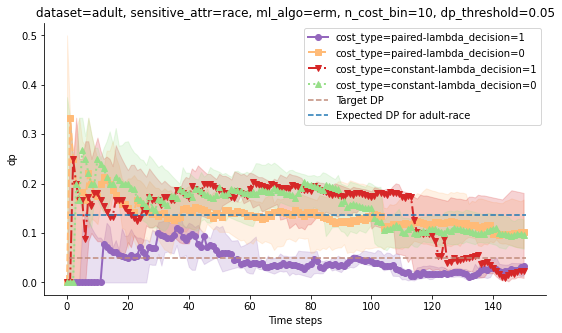

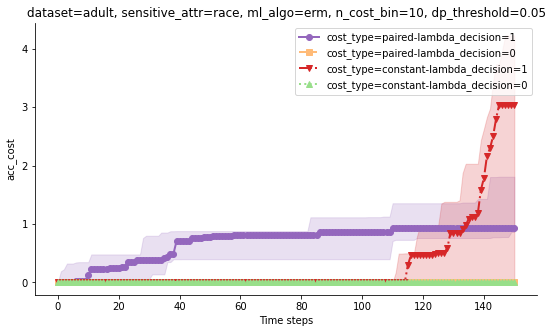

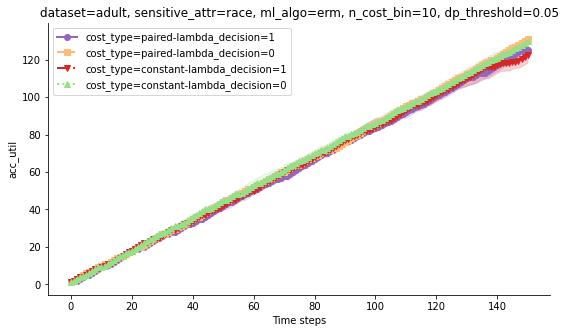

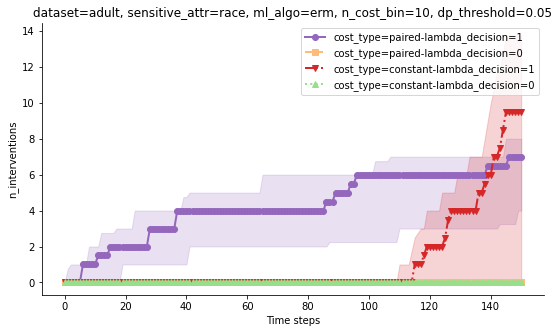

In [72]:

to_plot_params = {
    "dataset": ["adult"],
    "sensitive_attr" :  ["race"],
    "ml_algo" : ["erm"],
    "cost_type" : ["paired", "constant"],
    "n_cost_bin" : [10],
    "lambda_decision" : [1, 0],
    "dp_threshold" : [0.05]
}

make_plots(to_plot_params)